In [1]:
import torch
from new_SingleSessionSingleTrialDataset_OtherWay import SingleSessionSingleTrialDataset_OtherWay
import numpy as np
from pynwb import NWBHDF5IO

import os

dataset_path = "000070"
nwb_file_path = os.path.join(
    dataset_path, "sub-Jenkins", "sub-Jenkins_ses-20090916_behavior+ecephys.nwb")
io = NWBHDF5IO(nwb_file_path, 'r')
nwb_file = io.read()
hand_data = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].data[:]
hand_timestamps = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].timestamps[:]
trial_data = nwb_file.intervals['trials']

unit_spike_times = [nwb_file.units[unit_id]['spike_times'].iloc[0][:]
                    for unit_id in range(len(nwb_file.units))]
n_neurons = len(unit_spike_times)
n_future_vel_bins = 20

n_trials = 2000
datasets = [SingleSessionSingleTrialDataset_OtherWay(
    trial_data, hand_data, hand_timestamps, unit_spike_times, trial_id, bin_size=0.02, n_future_vel_bins=n_future_vel_bins) for trial_id in range(n_trials)]
dataset = torch.utils.data.ConcatDataset(datasets)
print(f"Dataset from {n_trials} trials has {len(dataset)} samples")

/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Dataset from 2000 trials has 2000 samples


In [2]:
n_fr_bins = 9

from torch.utils.data import DataLoader, random_split
from torch.utils.data._utils.collate import default_collate

def custom_collate(batch):
    # Sort batch by sequence length in descending order
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)
    
    # Create list of tensors with different first dimensions
    velocities = [item[0] for item in batch]
    spikes = [item[1] for item in batch]
    spikes_future = [item[2] for item in batch]
    
    # Create nested tensor
    spikes = torch.nested.nested_tensor(spikes)
    velocities = torch.nested.nested_tensor(velocities)
    spikes_future = torch.nested.nested_tensor(spikes_future)
    
    return velocities, spikes, spikes_future

# Calculate split sizes
total_size = len(dataset)
train_size = int(0.9 * total_size)  # 90% for training
test_size = total_size - train_size  # Remaining 10% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Use custom collate function to handle variable sequence lengths
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=200, collate_fn=custom_collate)

In [3]:
max_trial_length = max(dataset[i][0].shape[0] for i in range(len(dataset)))
max_trial_length = max(max_trial_length, 4 * 50) # 4 second trial max at least

In [17]:
n_fr_bins = 9

from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d_model = 512

class LinearEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        
    def forward(self, x):
        # input shape: (batch_size, n_neurons, n_context_bins)
        return self.linear(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model=d_model, max_len=max_trial_length):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(2*max_len) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (seq_len, batch_size, d_model)
        return x + self.pe[:x.size(0)]

# Define model
input_size = (n_neurons) + 2 * n_future_vel_bins  
hidden_size = d_model
    
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, n_neurons, n_fr_bins, max_trial_length):
        super().__init__()
        self.input_linear = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                dim_feedforward=4*d_model,
                nhead=8,
                batch_first=True,
                norm_first=True,
                dropout=0.2
            ),
            num_layers=4,
            enable_nested_tensor=False
        )
        self.output_linear = nn.Linear(d_model, n_neurons * n_fr_bins)
        self.unflatten = nn.Unflatten(2, (n_neurons, n_fr_bins))
        self.register_buffer('causal_mask', 
                           nn.Transformer.generate_square_subsequent_mask(max_trial_length))

    def forward(self, spikes, velocities):
        batch_size, n_context_bins, n_features = spikes.shape
        x = torch.cat((spikes, velocities.reshape(batch_size, n_context_bins, -1)), dim=2)
        x = self.input_linear(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x, mask=self.causal_mask[:n_context_bins, :n_context_bins])
        x = self.output_linear(x)
        x = self.unflatten(x)
        return x

model = TransformerModel(input_size, hidden_size, n_neurons, n_fr_bins, max_trial_length).to(device)

In [18]:
# Load model checkpoint
checkpoint = torch.load('model_checkpoint_epoch_10.pt')
model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss'] 
val_loss = checkpoint['val_loss']
test_acc = checkpoint['test_acc']
print(f"Loaded from checkpoint. val_loss {val_loss}, test_acc {test_acc}")

Loaded from checkpoint. val_loss 1.097105622291565, test_acc 0.32821065187454224


In [13]:
import torch.optim as optim
import torch.nn as nn

# Training parameters
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
n_epochs = 10

# Lists to store metrics
train_losses = []
val_losses = []
test_accs = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch_velocities, batch_spikes, batch_spikes_future in train_loader:
        batch_spikes = batch_spikes.to_padded_tensor(-100).to(device)
        batch_spikes_future = batch_spikes_future.to_padded_tensor(-100).to(device, dtype=torch.long)
        batch_velocities = batch_velocities.to_padded_tensor(-100).to(device)
        batch_size = batch_spikes.shape[0]
        n_context_bins = batch_spikes.shape[1]

        optimizer.zero_grad()
        outputs = model(batch_spikes, batch_velocities)
        
        loss = criterion(outputs.reshape(-1, n_fr_bins), batch_spikes_future.reshape(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        test_acc = 0
        for batch_velocities, batch_spikes, batch_spikes_future in test_loader:
            batch_spikes = batch_spikes.to_padded_tensor(-100).to(device)
            batch_spikes_future = batch_spikes_future.to_padded_tensor(-100).to(device, dtype=torch.long)
            batch_velocities = batch_velocities.to_padded_tensor(-100).to(device)

            outputs = model(batch_spikes, batch_velocities)
            
            # Get predicted classes
            pred_classes = torch.argmax(outputs, dim=3)  # Shape: (batch, n_context_bins-1, n_neurons)
            
            # Calculate accuracy
            acc = (pred_classes == batch_spikes_future).float().mean()
            test_acc += acc.item()
            val_loss += criterion(outputs.reshape(-1, n_fr_bins), batch_spikes_future.reshape(-1)).item()
            
        avg_val_loss = val_loss / len(test_loader)
        avg_test_acc = test_acc / len(test_loader)
        
        val_losses.append(avg_val_loss)
        test_accs.append(avg_test_acc)
    
    # Save model checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'test_acc': avg_test_acc
    }
    torch.save(checkpoint, f'model_checkpoint_epoch_{epoch+1}.pt')
    
    if (epoch + 1) % 1 == 0:
        print(f"\nEpoch {epoch+1}/{n_epochs} | Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f} | Test Acc: {avg_test_acc:.3f}")


Epoch 1/10 | Train Loss: 1.718 | Val Loss: 1.431 | Test Acc: 0.296


KeyboardInterrupt: 

In [19]:
model.eval()

TransformerModel(
  (input_linear): Linear(in_features=232, out_features=512, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (output_linear): Linear(in_features=512, out_features=1728, bias=True)
  (unflatten): Unflatten(dim=2, unflattened_size=(192, 9))
)

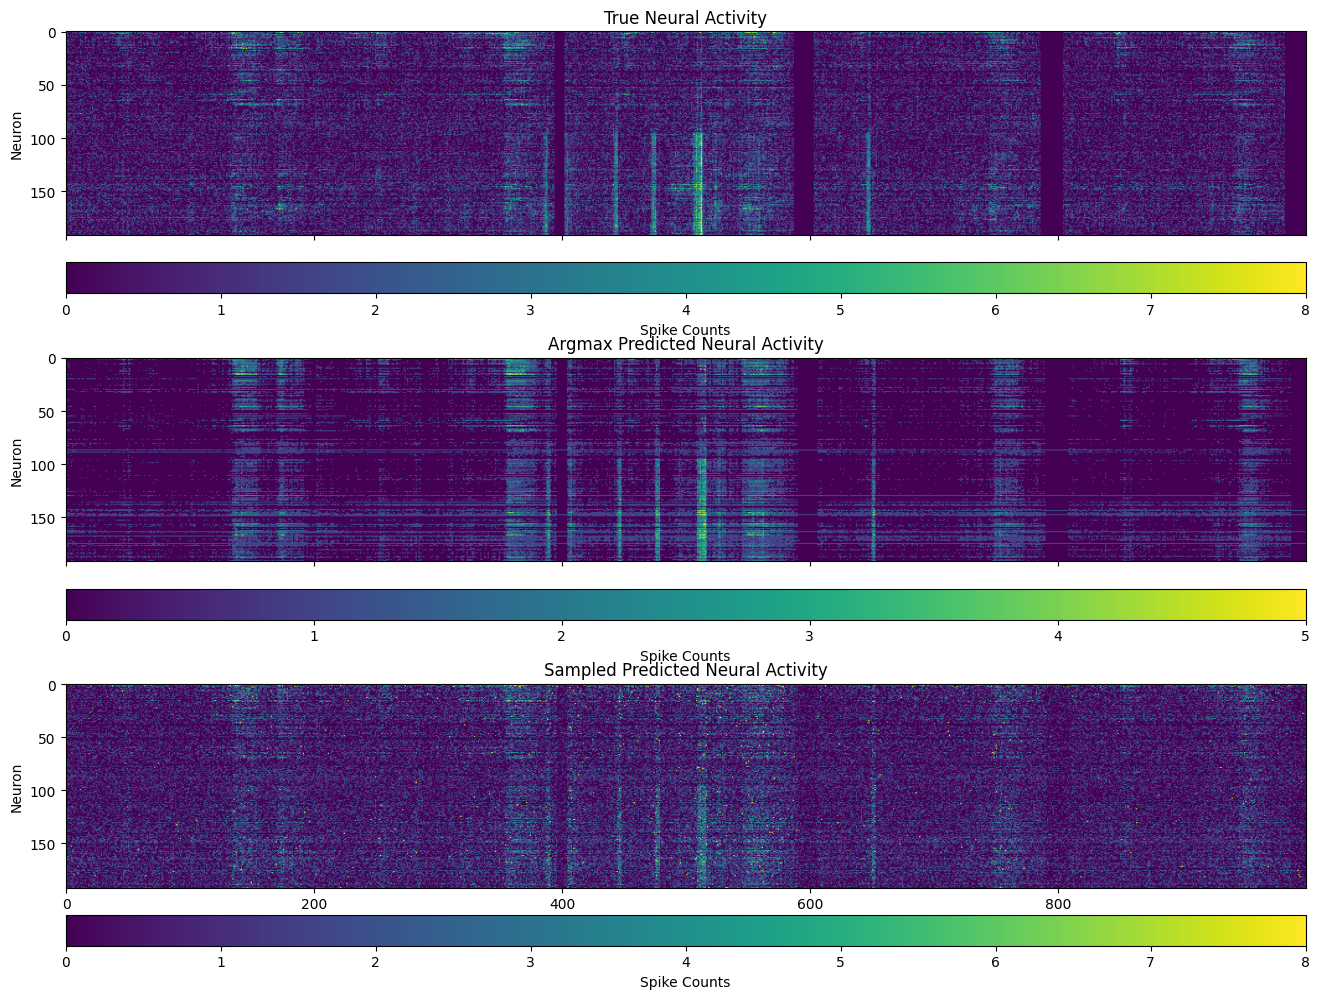

In [22]:
with torch.no_grad():
    # Get a single batch from test loader
    batch_velocities, batch_spikes, batch_spikes_future = next(iter(test_loader))
    batch_spikes = batch_spikes.to_padded_tensor(0).to(device)
    batch_velocities = batch_velocities.to_padded_tensor(0).to(device)
    
    # Get model predictions
    outputs = model(batch_spikes, batch_velocities)  # Shape: (batch, n_context_bins-1, n_neurons, n_fr_bins)
    
    # Apply temperature scaling
    temperature = 1.0  # Higher = more random, lower = more deterministic
    scaled_outputs = outputs / temperature
    test_pred_probs = torch.softmax(scaled_outputs, dim=3)  # Get probabilities
    
    # Get both argmax and sampled predictions
    pred_classes = torch.argmax(outputs, dim=3).cpu().numpy()
    test_pred_sample = torch.multinomial(test_pred_probs.reshape(-1, n_fr_bins), 1)
    test_pred_sample = test_pred_sample.reshape(outputs.shape[0], outputs.shape[1], outputs.shape[2]).cpu().numpy()

# Convert dataset to numpy arrays and visualize
import matplotlib.pyplot as plt

# Create figure with subplots and shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), height_ratios=[1, 1, 1], sharex=True)

# Plot heatmap of true data
max_show_timesteps = 1000
true_data = batch_spikes[:, 1:, :n_neurons].cpu().numpy()  # Get ground truth from next timesteps
im0 = ax1.imshow(true_data.reshape(-1, n_neurons)[:max_show_timesteps, :].T, aspect='auto', cmap='viridis')
ax1.set_title('True Neural Activity')
ax1.set_ylabel('Neuron')
plt.colorbar(im0, ax=ax1, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Plot heatmap of argmax predictions
im1 = ax2.imshow(pred_classes.reshape(-1, n_neurons)[:max_show_timesteps, :].T, aspect='auto', cmap='viridis')
ax2.set_title('Argmax Predicted Neural Activity')
ax2.set_ylabel('Neuron')
plt.colorbar(im1, ax=ax2, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Plot heatmap of sampled predictions
im2 = ax3.imshow(test_pred_sample.reshape(-1, n_neurons)[:max_show_timesteps, :].T, aspect='auto', cmap='viridis')
ax3.set_title('Sampled Predicted Neural Activity')
ax3.set_ylabel('Neuron')
ax3.set_xlabel('Time Step')
plt.colorbar(im2, ax=ax3, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')


In [27]:
model.eval()

# Initialize lists to store results
all_spikes = []
all_modified_spikes = []

# Loop through all trials in test dataset
for trial_idx in range(len(test_dataset)):
    if trial_idx>20: break # only do 20 trials
    # Get data for this trial
    velocities, spikes, spikes_future = test_dataset[trial_idx]
    spikes = spikes.to(device).unsqueeze(0)
    velocities = velocities.to(device).unsqueeze(0)

    # Create a copy that we'll modify
    n_context_bins = 70
    modified_spikes = spikes.clone()
    modified_spikes[:, n_context_bins:, :] = 0

    temperature = 1.0  # Add temperature parameter (higher = more random, lower = more deterministic)

    for i in range(n_context_bins, modified_spikes.size(1)):
        # Get model predictions
        outputs = model(modified_spikes[:, :i, :], 
                       velocities[:, :i, :])
        
        # Sample from probability distribution with temperature
        logits = outputs / temperature  # Apply temperature scaling
        pred_probs = torch.softmax(logits, dim=3)  # Get probabilities
        pred_sample = torch.multinomial(pred_probs.reshape(-1, n_fr_bins), 1)  # Sample from probabilities
        pred_sample = pred_sample.reshape(outputs.shape[0], outputs.shape[1], outputs.shape[2])
        
        # Update next timestep with predictions
        modified_spikes[:, i, :] = pred_sample[:, -1, :]
    
    # Store results for this trial
    all_spikes.append(spikes.squeeze(0))
    all_modified_spikes.append(modified_spikes.squeeze(0))

# Concatenate results from all trials
all_spikes = torch.cat(all_spikes, dim=0)
all_modified_spikes = torch.cat(all_modified_spikes, dim=0)

print(f"All spikes shape: {all_spikes.shape}")
print(f"All modified spikes shape: {all_modified_spikes.shape}")


All spikes shape: torch.Size([2744, 192])
All modified spikes shape: torch.Size([2744, 192])


Text(0, 0.5, 'Neuron')

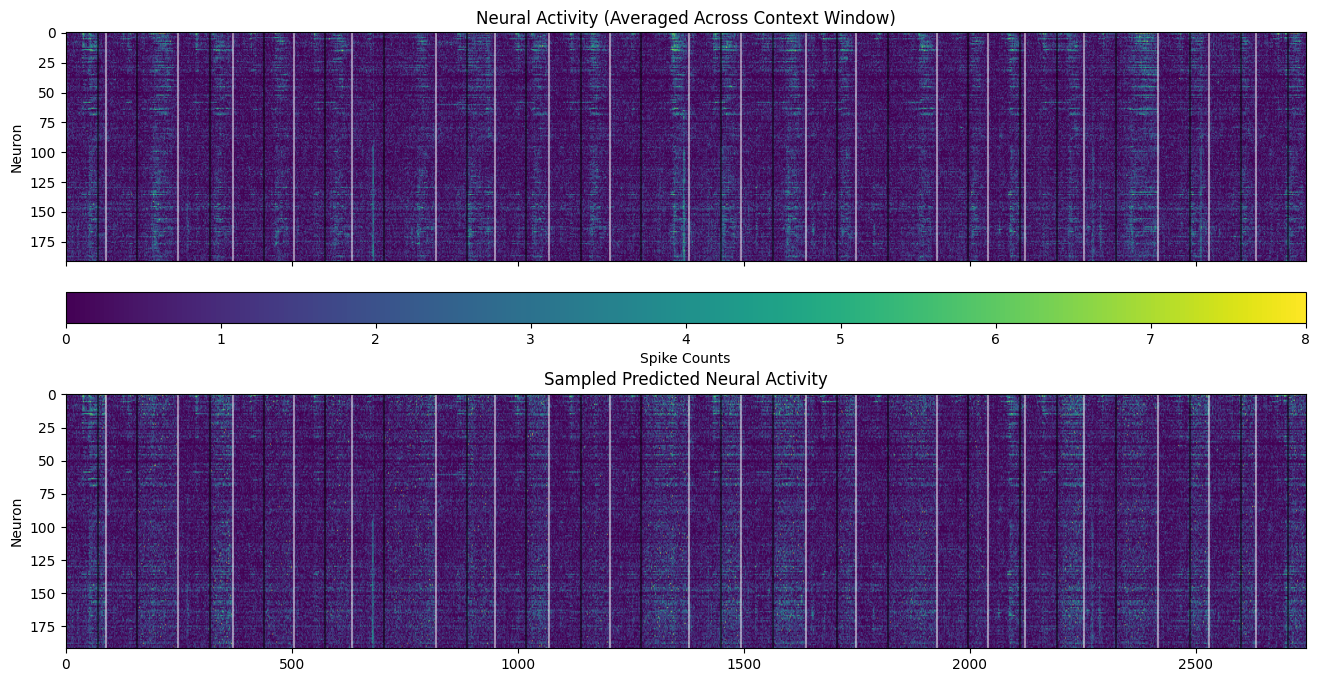

In [28]:
import matplotlib.pyplot as plt

# Create figure with subplots and shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), height_ratios=[1.2, 1], sharex=True)

im = ax1.imshow(all_spikes.cpu().numpy().T, aspect='auto', cmap='viridis')
ax1.set_title('Neural Activity (Averaged Across Context Window)')
ax1.set_ylabel('Neuron')
# Add smaller colorbar at the top
cbar = plt.colorbar(im, ax=ax1, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Add vertical lines for trial boundaries and context windows
trial_lengths = [len(test_dataset[i][0]) for i in range(21)]
current_pos = 0
for length in trial_lengths:
    # Add trial boundary line
    ax1.axvline(x=current_pos, color='white', linestyle='-', alpha=0.5)
    ax2.axvline(x=current_pos, color='white', linestyle='-', alpha=0.5)
    
    # Add context window line
    context_pos = current_pos + n_context_bins
    ax1.axvline(x=context_pos, color='black', linestyle='-', alpha=0.5)
    ax2.axvline(x=context_pos, color='black', linestyle='-', alpha=0.5)
    
    current_pos += length

im = ax2.imshow(all_modified_spikes.cpu().numpy().T, aspect='auto', cmap='viridis')
ax2.set_title('Sampled Predicted Neural Activity')
ax2.set_ylabel('Neuron')
